In [1]:
import pandas as pd
import datetime

fee = 1.5
delta = 0.95
account_size = 10000
stop_loss = 500

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=20)
validation_date = datetime.date(year=2016, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

In [2]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

In [3]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')

In [4]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


In [5]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [6]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

In [7]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

In [8]:
def create_labels(df, treshold):
    global fee, delta, stop_loss
    def calculate_target(row):
        # print(type(row))
        # print(row.shape)
        volatility = (row['Settle']-row['Open'])*delta
        if abs(volatility) > fee + treshold:
            if volatility > 0:
                if row['Open'] - row['Low'] > stop_loss:
                    return 0
                else:
                    return 1
            else:
                if row['High'] - row['Open'] > stop_loss:
                    return 0
                else:
                    return (-1)
        else:
            return 0
    ans_df = pd.DataFrame([])
    # ans_df = df.copy()
    # ans_df['target'] = df['Settle'] - df['Open']
    ans_df['target'] = df.apply(calculate_target, axis=1)
    ans_df.target = ans_df.target.shift(-1)
    return ans_df


def create_trade_outcomes(df, contracts):
    global fee, treshold, delta
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    return ans_df

In [9]:
gold_gains = create_trade_outcomes(gold, 100)
gold_gains.head(5)

,gains,Open,High,Low,Settle
Date,,,,,
1996-01-02,342.0,38830.0,39200.0,38800.0,39190.0
1996-01-03,361.0,39240.0,39630.0,39220.0,39620.0
1996-01-04,95.0,39440.0,39580.0,39410.0,39540.0
1996-01-05,-123.5,39780.0,39920.0,39620.0,39650.0
1996-01-09,104.5,39580.0,39710.0,39480.0,39690.0


In [10]:
treshold = 300

get_wr(gold, 14)
gold_label = create_labels(gold_gains, treshold)
gold['target'] = gold_label.target
tot, trade = gold.shape[0], gold[gold.target != 0].shape[0]
print(tot, trade, float(trade/tot))

5781 2006 0.3469987891368275


In [11]:
gold['target'].hist()

In [12]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
corn_gains = create_trade_outcomes(corn, 50)
corn_gains.head(5)

,gains,Open,High,Low,Settle
Date,,,,,
1996-01-02,106.875,18550.0,18762.5,18512.5,18662.5
1996-01-03,47.500,18650.0,18725.0,18512.5,18700.0
1996-01-04,-213.750,18675.0,18687.5,18250.0,18450.0
1996-01-05,-11.875,18337.5,18450.0,18275.0,18325.0
1996-01-08,-190.000,18225.0,18225.0,18000.0,18025.0


5790 1895 0.32728842832469773


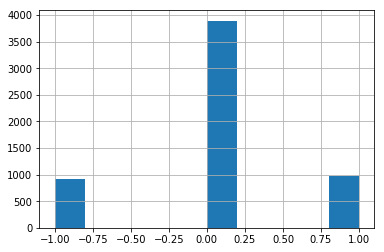

In [231]:
treshold = 200

get_wr(corn, 14)
corn_label = create_labels(corn_gains, treshold)
corn['target'] = corn_label.target
tot, trade = corn.shape[0], corn[corn.target != 0].shape[0]
print(tot, trade, float(trade/tot))

corn.target.hist()

In [232]:
corn.head(5)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,371.00,375.25,370.25,373.25,258495.0,1466855.0,40.000000,0.0
1996-01-03,373.00,374.50,370.25,374.00,259050.0,1426400.0,25.000000,-1.0
1996-01-04,373.50,373.75,365.00,369.00,392195.0,1389390.0,60.975610,0.0
1996-01-05,366.75,369.00,365.50,366.50,245720.0,1359685.0,85.365854,0.0
1996-01-08,364.50,364.50,360.00,360.50,297685.0,1329650.0,96.721311,1.0


In [233]:
# coffee contract size is 37,500 pounds price is in cents per pound
coffee_gains = create_trade_outcomes(coffee, 375)
coffee_gains.head(5)

,gains,Open,High,Low,Settle
Date,,,,,
1996-01-02,-480.9375,34725.0,35550.00,34162.5,34218.75
1996-01-03,1015.3125,34087.5,35400.00,33900.0,35156.25
1996-01-04,1727.8125,34875.0,36787.50,34875.0,36693.75
1996-01-05,-445.3125,36562.5,37293.75,35925.0,36093.75
1996-01-10,890.6250,35775.0,36843.75,35550.0,36712.50


5752 1963 0.34127260083449235


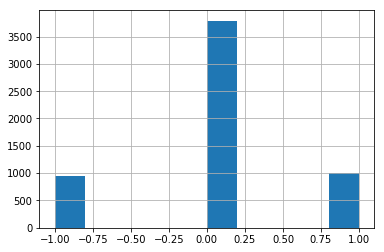

In [234]:
treshold = 300

get_wr(coffee, 14)
coffee_label = create_labels(coffee_gains, treshold)
coffee['target'] = coffee_label.target
tot, trade = coffee.shape[0], coffee[coffee.target != 0].shape[0]
print(tot, trade, float(trade/tot))

coffee.target.hist()

In [235]:
coffee[coffee.target != 0].head(10)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,92.60,94.80,91.10,91.25,5719.0,18717.0,95.945946,1.0
1996-01-03,90.90,94.40,90.40,93.75,6461.0,19257.0,23.863636,1.0
1996-01-05,97.50,99.45,95.80,96.25,6833.0,18599.0,35.359116,1.0
1996-01-10,95.40,98.25,94.80,97.90,5146.0,18542.0,17.127072,1.0
1996-01-12,103.00,103.85,100.80,102.70,5984.0,17314.0,8.550186,-1.0
1996-01-15,102.70,103.00,98.70,98.95,6128.0,17227.0,36.431227,1.0
1996-01-16,97.75,105.25,97.75,103.90,9918.0,17601.0,9.090909,1.0
1996-01-19,105.00,107.25,103.60,104.65,5710.0,15884.0,15.430267,1.0
1996-01-23,107.25,109.40,106.60,107.00,6907.0,15103.0,12.631579,1.0


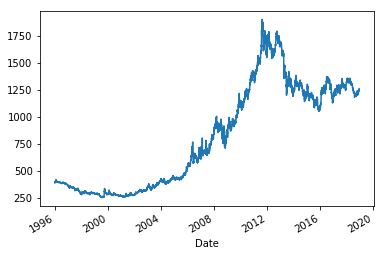

In [236]:
gold['Open'].plot()

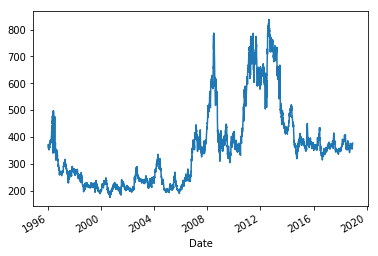

In [237]:
corn['Open'].plot()

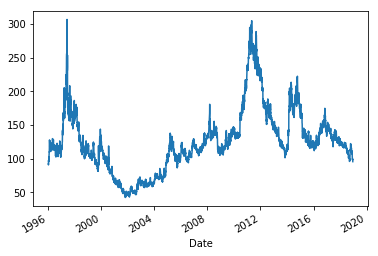

In [238]:
coffee['Open'].plot()

In [239]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        # print(type(idx), type(idx.astype(datetime.datetime)))
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [240]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

In [241]:
gold_data.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045
2018-11-23,1213.5,1220.9,1205.6,1211.2,202123.0,199751.0,1212.6,1214.7,1181.2,1189.3,...,0.942235,0.087364,0.916625,0.162104,4,17,11,3,36.363636,0.0
2018-11-26,1212.6,1214.7,1181.2,1189.3,353644.0,164500.0,1189.4,1192.7,1170.3,1178.4,...,0.942235,0.087364,0.916625,0.162104,0,18,11,3,38.277512,-1.0
2018-11-27,1189.4,1192.7,1170.3,1178.4,288389.0,106069.0,1184.4,1197.2,1182.4,1190.8,...,0.942235,0.087364,0.916625,0.162104,1,19,11,3,59.808612,1.0
2018-11-28,1184.4,1197.2,1182.4,1190.8,177818.0,77556.0,1196.6,1197.7,1182.6,1190.8,...,0.916625,0.162104,0.957183,0.139100,2,20,11,3,21.282799,0.0
2018-11-29,1196.6,1197.7,1182.6,1190.8,196186.0,259190.0,1190.7,1196.8,1171.3,1173.9,...,0.916625,0.162104,0.957183,0.139100,3,21,11,3,19.825073,-1.0
2018-11-30,1190.7,1196.8,1171.3,1173.9,236195.0,271613.0,1175.1,1178.4,1162.2,1169.4,...,0.916625,0.162104,0.957183,0.139100,4,22,11,3,31.195335,1.0
2018-12-03,1175.1,1178.4,1162.2,1169.4,216866.0,273896.0,1174.3,1180.3,1168.4,1177.8,...,0.916625,0.162104,0.957183,0.139100,0,1,12,3,0.533333,1.0
2018-12-04,1174.3,1180.3,1168.4,1177.8,169593.0,273718.0,1182.6,1190.2,1158.6,1176.5,...,0.916625,0.162104,0.957183,0.139100,1,2,12,3,0.692841,0.0
2018-12-05,1182.6,1190.2,1158.6,1176.5,212507.0,275782.0,1172.8,1177.1,1168.1,1170.1,...,0.957183,0.139100,0.859876,0.275776,2,3,12,3,12.536443,0.0
2018-12-06,1172.8,1177.1,1168.1,1170.1,131034.0,271766.0,1171.4,1182.3,1167.2,1177.5,...,0.957183,0.139100,0.859876,0.275776,3,4,12,3,18.584071,1.0


In [242]:
gold_data.shape

(5276, 3046)

In [243]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [244]:
gold_data = gold_data[gold_data.index >= '2007-01-01']
corn_data = corn_data[corn_data.index >= '2007-01-01']
coffee_data = coffee_data[coffee_data.index >= '2007-01-01']

In [336]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


def data_split_pca_transform(df):
    label_index = 3045
    df_validate = df.loc['2016-01-01' <= df.index]
    df_data_tt = df.loc['2016-01-01' > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)

    # pca_lst = []
    pca = PCA(n_components=10, random_state=2234)
    pca.fit(df_train[list(range(3024))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2233)
    # pca.fit(df_train[list(range(2016, 2016 + 504))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2232)
    # pca.fit(df_train[list(range(2016 + 504, 2016 + 1008))])
    # pca_lst.append(pca)

    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_data_tt[label_index], pca


def pca_transform(df, pca):
    label_index = 3045
    # df_pca_lst = []
    df_pca = pca.transform(df[list(range(3024))])
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[1].transform(df[list(range(2016, 2016 + 504))])
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[2].transform(df[list(range(2016 + 504, 2016 + 1008))])
    # df_pca_lst.append(df_pca)
    
    df_pca = np.concatenate((df_pca, df[list(range(3025,label_index))].values), axis=1)
    return df_pca

In [337]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

In [338]:
gold_label_train.unique()

array([-1.,  0.,  1.])

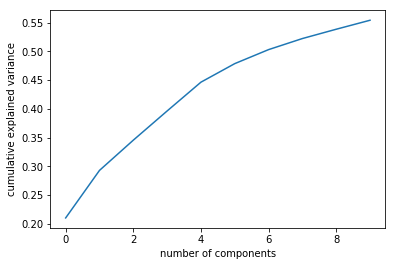

In [339]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(gold_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [340]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [341]:
def plot_pca_relation(pca_data, label_train, x):
    labels = [0, 1, -1]
    labl={-1: 'Short', 0:'No Trade', 1:'Long'}
    plt.figure(1)

    for i in range(x):
        for j in range(i+1, x):
            fig, ax = plt.subplots(figsize=(7,5))
            fig.patch.set_facecolor('white')
            Xax = pca_data[:, i]
            Yax = pca_data[:, j]
            for l in labels:
                ix = np.where(label_train==l)
                ax.scatter(Xax[ix], Yax[ix], label=labl[l])

            plt.xlabel("Principal Component No " + str(i), fontsize=14)
            plt.ylabel("Second Principal Component No " + str(j), fontsize=14)
            plt.legend()
            plt.show()

In [342]:
pca_components = 3

In [343]:
# plot_pca_relation(gold_pca[0].transform(gold_train[list(range(2016))]), gold_label_train, pca_components)

In [344]:
# plot_pca_relation(corn_pca[0].transform(corn_train[list(range(2016))]), corn_label_train, pca_components)

In [345]:
# plot_pca_relation(coffee_pca[0].transform(coffee_train[list(range(2016))]), coffee_label_train, pca_components)

In [346]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
import lightgbm as lgb
import xgboost as xgb


# X = pca_transform(gold_train, gold_pca)
# train_data = lgb.Dataset(X, label=gold_label_train,) # categorical_feature=[3040,3041,3042,3043])
# X_test = pca_transform(gold_test, gold_pca)
# test_data = lgb.Dataset(X_test, label=gold_label_test)
# param = {'num_leaves':31, 'objective':'binary'}
# param['metric'] = 'auc'
# param['metric'] = 'binary_logloss'
# param['max_bin'] = 40
# num_round = 500
# gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

# gold_clf = RandomForestClassifier(n_estimators=150, random_state=1100)
# gold_clf = AdaBoostClassifier(n_estimators=100, random_state=1100, learning_rate=0.1)
# gold_clf = MLPClassifier(hidden_layer_sizes=(100, 3), solver='sgd', random_state=1100)
# gold_clf = MLPRegressor(hidden_layer_sizes=(100, 3), solver='sgd', max_iter=2000, alpha=0.1, random_state=1100)
# sample_weight = list(map(lambda x: 2 if x != 0 else 1, gold_label_train))
# gold_clf.fit(X, gold_label_train)
# gold_clf.fit(X, gold_label_train, sample_weight=sample_weight)

In [347]:
X_test = pca_transform(gold_test, gold_pca)

# gold_clf.score(X_test, gold_label_test)

In [411]:
X = pca_transform(corn_train, corn_pca)

train_data = lgb.Dataset(X, label=corn_label_train, categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(corn_test, corn_pca)
test_data = lgb.Dataset(X_test, label=corn_label_test)
param = {'num_leaves':31, 'objective':'binary'}
# param['metric'] = 'auc'
param['metric'] = 'binary_logloss'
param['max_bin'] = 50
num_round = 500
# corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])
sample_weight = list(map(lambda x: 2 if x != 0 else 1, corn_label_train))
dtrain = xgb.DMatrix(X, label=list(map(lambda x: x+1, corn_label_train)), weight=sample_weight)
test_weight = list(map(lambda x: 2 if x != 0 else 1, corn_label_train))
dtest = xgb.DMatrix(X_test, label=list(map(lambda x: x+1, corn_label_test)), weight=test_weight)
evallist = [(dtrain, 'train'), (dtest, 'eval')]
param = {'max_depth': 50, 'eta': 1, 'silent': 1}
param['booster'] = 'dart'
param['nthread'] = 3
param['objective'] = 'multi:softmax'
param['objective'] = 'reg:linear'
param['num_class'] = 3
param['eval_metric'] = 'mlogloss'
# corn_clf = xgb.train(param, dtrain, num_round, evallist)
corn_clf = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=100, objective='reg:logistic',
                             booster='dart', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None)
print(np.unique(list(map(lambda x: (x+1)/2, corn_label_train))))
corn_clf.fit(X, list(map(lambda x: (x+1)/2, corn_label_train)))

# corn_clf = AdaBoostClassifier(n_estimators=150, learning_rate=0.5, random_state=1100)
# corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])
# corn_clf = RandomForestClassifier(n_estimators=100, random_state=1100)
sample_weight = list(map(lambda x: 3 if x != 0 else 1, corn_label_train))
# corn_clf.fit(X, corn_label_train)
# corn_clf.predict(X)

[0.  0.5 1. ]


In [412]:
# X = pca_transform(coffee_train, coffee_pca)

# train_data = lgb.Dataset(X, label=coffee_label_train,) # categorical_feature=[3040,3041,3042,3043])
# X_test = pca_transform(coffee_test, coffee_pca)
# test_data = lgb.Dataset(X_test, label=coffee_label_test)
# param = {'num_leaves':31, 'objective':'binary'}
# param['booster'] = 'gbtree'
# param['metric'] = 'binary_logloss'
# param['max_bin'] = 50
# num_round = 100
# # coffee_clf = lgb.train(X, label=coffee_label_train)
# coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

In [413]:
# X_test = pca_transform(corn_test, corn_pca)
# corn_clf.score(X_test, corn_label_test)

In [418]:
def get_performance(model, pca, df_gains, df, labels, xgb_use=False):
    global account_size, fee, stop_loss
    acc = account_size
    df = pca_transform(df, pca)
    if not xgb_use:
        predictions = model.predict(df)
    else:
        # data = xgb.DMatrix(df)
        # predictions = list(map(lambda x: x*2-1, model.predict(data)))
        predictions = list(map(lambda x: x*2-1, model.predict(df)))
        print(np.unique(predictions))
    # print(predictions)
    dct = {}
    dct['account'] = [acc]
    for p, l, v in zip(predictions, labels, df_gains.values):
        print(p,l)
        # print(p)
        if p > 0.5:
            if (v[1] - v[3]) > stop_loss:
                acc -= stop_loss
            else:
                acc += v[0] - fee
        elif p < -0.5:
            if (v[2] - v[1]) > stop_loss:
                acc -= stop_loss
            else:
                acc -= v[0] - fee
        dct['account'].append(acc)
        if acc <= 0:
            break
    return pd.DataFrame.from_dict(dct)

In [419]:
# gold_account = get_performance(gold_clf, gold_pca, gold_gains[gold_gains.index > '2016-01-01'], gold_validate, gold_label_validate)
# gold_account.plot()

[-7.05427855e-01 -6.60455018e-01 -6.43848062e-01 -6.41417384e-01
 -6.14136517e-01 -6.02836043e-01 -5.97960532e-01 -5.91374546e-01
 -5.89309335e-01 -5.83250701e-01 -5.73465139e-01 -5.73095530e-01
 -5.70591331e-01 -5.63887596e-01 -5.62718809e-01 -5.62174171e-01
 -5.60140312e-01 -5.42703420e-01 -5.34562141e-01 -5.34003913e-01
 -5.33927500e-01 -5.33872157e-01 -5.32864302e-01 -5.31192034e-01
 -5.21086872e-01 -5.19561172e-01 -5.16935974e-01 -5.14734179e-01
 -5.12195855e-01 -5.10794729e-01 -5.07320195e-01 -5.06120414e-01
 -4.95619357e-01 -4.92571473e-01 -4.90889430e-01 -4.90440130e-01
 -4.88695800e-01 -4.86216068e-01 -4.83674824e-01 -4.80667651e-01
 -4.79652166e-01 -4.74376202e-01 -4.73520398e-01 -4.67524052e-01
 -4.65923548e-01 -4.65063810e-01 -4.60600674e-01 -4.57459748e-01
 -4.51967716e-01 -4.49010372e-01 -4.48372126e-01 -4.45478857e-01
 -4.43678081e-01 -4.41839516e-01 -4.39725816e-01 -4.38597620e-01
 -4.34755564e-01 -4.32189524e-01 -4.32149053e-01 -4.31856990e-01
 -4.30378020e-01 -4.29831

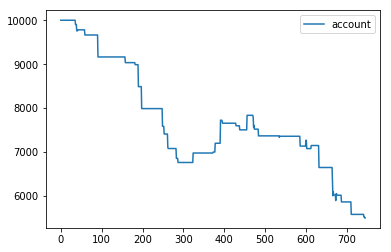

In [420]:
corn_account = get_performance(corn_clf, corn_pca, corn_gains[corn_gains.index > '2016-01-01'], corn_validate, corn_label_validate, xgb_use=True)
corn_account.plot()

In [204]:
# coffee_account = get_performance(coffee_clf, coffee_pca, coffee_gains[coffee_gains.index > '2016-01-01'], coffee_validate, coffee_label_validate)
# coffee_account.plot()